In [1]:
using CSV, DataFrames
using LinearAlgebra
using PyPlot
using Test
using Printf
using Statistics
using Combinatorics
using Colors

In [2]:
#Have an GUI plot window pop up
pygui(false)

false

In [4]:
#Read in MOFs

_df_henry = CSV.read("../data/expt_henry_coefs.csv")
for (i, xtal) in enumerate(_df_henry[:crystal])
    # Check replace() out for string replacement
    _df_henry[i, :crystal] = split(split(_df_henry[i, :crystal], ".cif")[1], "_")[1]
end
dropmissing!(_df_henry)
global const df_henry = deepcopy(_df_henry)

,crystal,CO2_henry coefficient [mmol/(g-bar)],Temperature [K],H2O_henry coefficient [mmol/(g-bar)],Temperature [K]_1
,String⍰,Float64⍰,Int64⍰,Float64⍰,Int64⍰
1,Al-MIL-53,9.91398,304,117.0,298
2,MIL-101,0.733852,303,968.0,298
3,MIL-101-NH2,43.3033,293,4050.0,298
4,MIL-101-NO2,3.57533,293,503.0,298
5,MIL-125,2.04678,298,27500.0,298
6,MIL-125-NH2,3.63076,298,31000.0,298
7,MIL-68,2.64339,298,25.3,298
8,MIL-68-NH2,4.05345,298,117.0,298
9,SIM-1,8.05867,303,133.0,298


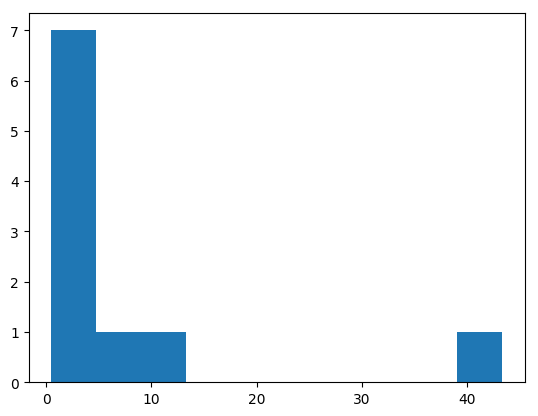

([7.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.471066, 4.75429, 9.03751, 13.3207, 17.604, 21.8872, 26.1704, 30.4536, 34.7368, 39.0201, 43.3033], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7f76fc089518>, PyObject <matplotlib.patches.Rectangle object at 0x7f76fc089320>, PyObject <matplotlib.patches.Rectangle object at 0x7f76fc089860>, PyObject <matplotlib.patches.Rectangle object at 0x7f76fc089ba8>, PyObject <matplotlib.patches.Rectangle object at 0x7f76fc089ef0>, PyObject <matplotlib.patches.Rectangle object at 0x7f76fc0962b0>, PyObject <matplotlib.patches.Rectangle object at 0x7f76fc096630>, PyObject <matplotlib.patches.Rectangle object at 0x7f76fc0969b0>, PyObject <matplotlib.patches.Rectangle object at 0x7f76fc096d30>, PyObject <matplotlib.patches.Rectangle object at 0x7f76fc09c0f0>])

In [5]:
data = df_henry[Symbol("CO2_henry coefficient [mmol/(g-bar)]")]
plt[:hist](data)

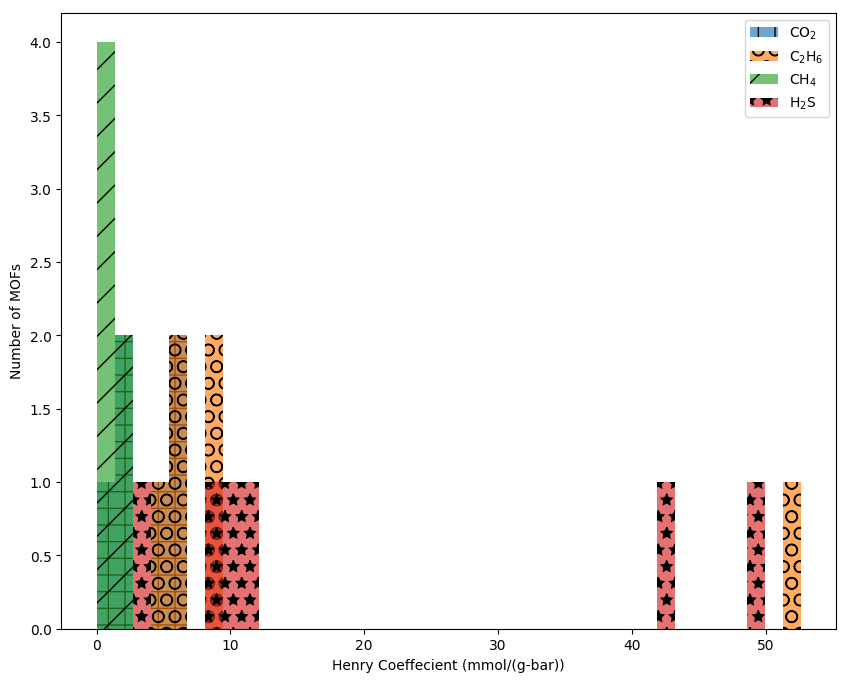

Float64

PyObject Text(0.5,1,'')

In [5]:
function plot_histogram()
    fig = figure(figsize=(10,8))
    gases = ["CO2", "C2H6", "CH4", "H2S"]
    gas_labels = [L"CO$_2$", L"C$_2$H$_6$", L"CH$_4$", L"H$_2$S"]
    gas_textures = ["+", "O", "/", "*"]
    bin_size = 1.35
    maximum_value = maximum([maximum(df_henry[Symbol(gases[i] * "_henry coefficient [mmol/(g-bar)]")]) for i = 1:length(gases)])
    print(typeof(maximum_value))
    for (i, gas) in enumerate(gases)
        plt[:hist](df_henry[Symbol(gas * "_henry coefficient [mmol/(g-bar)]")], label=gas_labels[i],
            alpha=0.65, bins=range(0, stop=maximum_value + bin_size, step=bin_size), hatch=gas_textures[i])
    end
    legend()
    # grid()
    xlabel("Henry Coeffecient (mmol/(g-bar))")
    ylabel("Number of MOFs")
    title("")
    
end
plot_histogram()

In [6]:
function perform_svd(gas1::AbstractString, gas2::AbstractString)
    #Should we create the program for comparing just two MOFs?
    #Or should it be able to compare 3 as well?

    # MOFs[1] indicates the length of the first column, eg. the number of MOFs being screened
    #initialize Henry's Matrix
    N = size(df_henry)[1]
    sigma = zeros(N, N, 2)

    for i = 1:N
        for j = i+1:N
            H = make_h_matrix2(i, j, gas1, gas2)
            F = svd(H)
            sigma[i, j, :] = F.S
        end
    end
    return sigma
end

perform_svd (generic function with 1 method)

In [7]:
function make_h_matrix(mof1::Int, mof2::Int, gas1::AbstractString, gas2::AbstractString)
    H = zeros(2,2)
    H[1, 1] = df_henry[mof1, Symbol(gas1 * "_henry coefficient [mmol/(g-bar)]")] - df_henry[mof1, Symbol("CH4_henry coefficient [mmol/(g-bar)]")]
    H[1, 2] = df_henry[mof1, Symbol(gas2 * "_henry coefficient [mmol/(g-bar)]")] - df_henry[mof1, Symbol("CH4_henry coefficient [mmol/(g-bar)]")]
    H[2, 1] = df_henry[mof2, Symbol(gas1 * "_henry coefficient [mmol/(g-bar)]")] - df_henry[mof2, Symbol("CH4_henry coefficient [mmol/(g-bar)]")]
    H[2, 2] = df_henry[mof2, Symbol(gas2 * "_henry coefficient [mmol/(g-bar)]")] - df_henry[mof2, Symbol("CH4_henry coefficient [mmol/(g-bar)]")]
    return H
end

make_h_matrix (generic function with 1 method)

In [8]:
function make_h_matrix2(mof1::Int, mof2::Int, gas1::AbstractString, gas2::AbstractString)
    H = zeros(2,2)
    H[1, 1] = df_henry[mof1, Symbol(gas1 * "_henry coefficient [mmol/(g-bar)]")]
    H[1, 2] = df_henry[mof1, Symbol(gas2 * "_henry coefficient [mmol/(g-bar)]")]
    H[2, 1] = df_henry[mof2, Symbol(gas1 * "_henry coefficient [mmol/(g-bar)]")]
    H[2, 2] = df_henry[mof2, Symbol(gas2 * "_henry coefficient [mmol/(g-bar)]")]
    return H
end

make_h_matrix2 (generic function with 1 method)

In [9]:
function make_h_matrix3(mof1::Int, mof2::Int, gas1::AbstractString, gas2::AbstractString)
    H = zeros(2,2)
    H[1, 1] = df_henry[mof1, Symbol(gas1 * "_henry coefficient [mmol/(g-bar)]")] - df_henry[mof1, Symbol("p_xylene_henry coefficient [mmol/(g-bar)]")]
    H[1, 2] = df_henry[mof1, Symbol(gas2 * "_henry coefficient [mmol/(g-bar)]")] - df_henry[mof1, Symbol("p_xylene_henry coefficient [mmol/(g-bar)]")]
    H[2, 1] = df_henry[mof2, Symbol(gas1 * "_henry coefficient [mmol/(g-bar)]")] - df_henry[mof1, Symbol("p_xylene_henry coefficient [mmol/(g-bar)]")]
    H[2, 2] = df_henry[mof2, Symbol(gas2 * "_henry coefficient [mmol/(g-bar)]")] - df_henry[mof1, Symbol("p_xylene_henry coefficient [mmol/(g-bar)]")]
    return H
end

make_h_matrix3 (generic function with 1 method)

In [10]:
sigma = perform_svd("CO2","H2O")

10×10×2 Array{Float64,3}:
[:, :, 1] =
 0.0  975.047  4051.92   516.46  27500.2  …    165.758    177.586    130.465 
 0.0    0.0    4164.29  1090.89  27517.0       975.046    977.096    969.677 
 0.0    0.0       0.0   4081.35  27796.6      4051.92    4052.42    4050.63  
 0.0    0.0       0.0      0.0   27504.6       516.447    520.316    506.232 
 0.0    0.0       0.0      0.0       0.0     27500.2    27500.3    27500.1   
 0.0    0.0       0.0      0.0       0.0  …  31000.2    31000.3    31000.1   
 0.0    0.0       0.0      0.0       0.0       119.79     135.646     62.3807
 0.0    0.0       0.0      0.0       0.0         0.0      177.353    130.203 
 0.0    0.0       0.0      0.0       0.0         0.0        0.0      144.899 
 0.0    0.0       0.0      0.0       0.0         0.0        0.0        0.0   

[:, :, 2] =
 0.0  9.75427  8.65888  8.84564   9.90518   …  4.13665  2.11557  3.90894 
 0.0  0.0      9.35225  2.83419   0.661396     3.9361   7.88376  0.427114
 0.0  0.0      0.0   

In [11]:
function argmin_without_zero(matrix::Array{Float64, 2})
    index = CartesianIndex(1,1)
    lowest = Inf
    for i = 1:size(matrix)[1]
        for j = 1:size(matrix)[2]
            if matrix[i,j] < lowest && !isapprox(matrix[i,j], 0.0)
                lowest = matrix[i,j]
                index = CartesianIndex(i,j)
            end
        end
    end
    return index, lowest
end
    

argmin_without_zero (generic function with 1 method)

In [12]:
idx, lowest = argmin_without_zero(sigma[:,:,1])

(CartesianIndex(7, 10), 62.38070032127974)

In [13]:
function analyze_svd(sigma::Array{Float64, 3})

    #initialize some arrays
    best_indices = argmax(sigma[:, :, 2]) # finds the largest σ₂ value
    #TODO Needs fixing. worst_indices doesn't work
    worst_indices = argmin_without_zero(sigma[:, :, 1])[1] # finds the smallest σ₁ value

    MOF1 = String(df_henry[best_indices[1], :crystal])
    MOF2 = String(df_henry[best_indices[2], :crystal])

    println("The most sensitive pair of MOFs is " * MOF1 * " and " * MOF2)

    MOF3 = String(df_henry[worst_indices[1], :crystal])
    MOF4 = String(df_henry[worst_indices[2], :crystal])

    println("The least sensitive pair of MOFs is " * MOF3 * " and " * MOF4)

    #error analysis?
    #Delta K/H?

#=
    #create circle array
    n = 1000
    #TODO change to range
    x_lin = linspace(-1,1,n)
    y = zeros(2*n)
    x = zeros(2*n)
    for i = 1:n
        y[2 * i] = sqrt(1 - (x_lin[i] ^ 2))
        y[2 * i - 1] = - sqrt(1 - (x_lin[i] ^ 2))
        x[2 * i] = x_lin[i]
        x[2 * i - 1] = x_lin[i]
    end

    xx = x
    yy = y

    pre_plot = plot(x = xx, y = yy, Geom.point, Guide.xlabel("x"), Guide.ylabel("y"))

    #formats the xy coords appropriately
    xy = hcat(x, y)
    xy = transpose(xy)

    #stretches the xy coords by the sigma from the svd
    highest_sigma = sigma[highest_index[1], highest_index[2]]
    sigma = [highest_sigma[1] 0; 0 highest_sigma[2]]
    println(sigma)
    xy_stretched = sigma*xy

    post_plot = plot(x = xy_stretched[1,:], y = xy_stretched[2,:], Geom.point, Guide.xlabel("x"), Guide.ylabel("y"))

    return post_plot
    =#
end

analyze_svd (generic function with 1 method)

In [14]:
function mof2index(mof::AbstractString)
    boolarray = mof .== df_henry[:crystal]
    if sum(boolarray) > 1
        @error "More than one MOF match the given MOF name"
    elseif sum(boolarray) == 0
        @error "No MOF matched the given MOF name"
    end
    return argmax(boolarray)
end

mof2index (generic function with 1 method)

In [68]:
function plot_response(mof1::Int, mof2::Int, gas1::AbstractString, gas2::AbstractString)
    H = make_h_matrix2(mof1, mof2, gas1, gas2)
    F = svd(H)
    θ = range(0, stop=2*π, length=500)[1:end-1]
    p = transpose(hcat(cos.(θ), sin.(θ))) # set pt change
    n = H * p # required input

    S = perform_svd(gas1, gas2)
    biggest_σ = maximum(S[:, :, 1])

    function plot_vector(x; head_length=0.05, head_width=0.05, color="k", label="", label_dist=0.05)
        x_plot = x - head_length * x / norm(x)
        arrow(0, 0, x_plot[1], x_plot[2], head_width=head_width,
            head_length=head_length, fc=color, ec=color, zorder=1000000)
        x_label = x + x / norm(x) * label_dist
        text(x_label[1], x_label[2], label)
    end

    cnorm = PyPlot.matplotlib[:colors][:Normalize](vmin=0.0, vmax=2 * π)

    m = plt[:cm][:ScalarMappable](norm=cnorm, cmap=plt[:cm][:hsv])
    m[:set_array]([]) # trick


    figure(figsize=(11, 5))
    subplot(121, aspect="equal")
    for i = 1:length(θ)-1
        plot(p[1, i:i+1], p[2, i:i+1], lw=5, c=m[:to_rgba](mean(θ[i:i+1])))
    end
    xlim([-1.1, 1.1])
    ylim([-1.1, 1.1])
    axis("equal")
    xlabel(@sprintf("\$p_{%s}^*\$ (bar)", gas1))
    ylabel(@sprintf("\$p_{%s}^*\$ (bar)", gas2))
    for k = 1:2
        plot_vector(F.V[:, k], color="k",
            label="\$\\mathbf{v}_$k\$", label_dist=0.1)
    end
    title("Composition Space")
    tight_layout()

    subplot(122, aspect="equal")
    ylim([-biggest_σ, biggest_σ])
    xlim([-biggest_σ, biggest_σ])
    for i = 1:length(θ)-1
        plot(n[1, i:i+1], n[2, i:i+1], lw=5, c=m[:to_rgba](mean(θ[i:i+1])))
    end
    for k = 1:2
        plot_vector(F.U[:, k] * F.S[k], head_length=0.005,
            head_width=0.05/3, color="k", label="\$\\sigma_$k\\mathbf{u}_$k\$", label_dist=0.025)
    end
    axis("equal")
    xlabel(@sprintf("\$n_{%i}^*\$ (mmol of total gas)", mof1))
    ylabel(@sprintf("\$n_{%i}^*\$ (mmol of total gas)", mof2))
    title("Response Space")
    tight_layout()
    savefig(@sprintf("composition_response_of_%i_and_%i.png", mof1, mof2), format="png", dpi=300)
end

plot_response(mof1::AbstractString, mof2::AbstractString, gas1::AbstractString, gas2::AbstractString) = plot_response(mof2index(mof1), mof2index(mof2), gas1, gas2)

plot_response (generic function with 2 methods)

In [71]:
function plot_all_responses(gas1::AbstractString, gas2::AbstractString, index_list::Union{Array{Int64, 1}, Missing}=missing; 
                            print_h_matrix::Bool=false, add_legend::Bool=false, color_by_sigma::Int64=2)
    
    if color_by_sigma > 2 || color_by_sigma < 1
        error("`color_by_sigma` has to be 1 or 2")
    end
    S = perform_svd(gas1, gas2)
    biggest_σ₂ = maximum(S[:, :, 2])
    
    
    figure(figsize=(11, 5))
    subplot(121, aspect="equal")
    θ = range(0, stop=2*π, length=500)[1:end-1]
    p = transpose(hcat(cos.(θ), sin.(θ))) # set pt change
    for i = 1:length(θ)-1
        plot(p[1, i:i+1], p[2, i:i+1], lw=2, c="k")
    end
    xlim([-1.1, 1.1])
    ylim([-1.1, 1.1])
    axis("equal")
    xlabel(@sprintf("\$p_{%s}^*\$ (bar)", gas1))
    ylabel(@sprintf("\$p_{%s}^*\$ (bar)", gas2))
    #for k = 1:2
    #    plot_vector(F.V[:, k], color="r",
    #        label="\$\\mathbf{v}_$k\$", label_dist=0.1)
    #end
    title("Composition Space")
    
    if index_list !== missing
        number_of_mofs = length(index_list)
        if number_of_mofs < 2
            @error "Need more than one index to plot the response!"
        end
        pairs = combinations(index_list, 2)
    else
        number_of_mofs = size(df_henry)[1]
        pairs = combinations(1:number_of_mofs, 2)
    end
    
#    cols = distinguishable_colors(size(collect(pairs))[1]+3, [RGB(1,1,1)])[4:end]
    ax = subplot(122)
    axis("equal")

    cnorm = PyPlot.matplotlib[:colors][:Normalize](vmin=0.0, vmax=biggest_σ₂)

    m = plt[:cm][:ScalarMappable](norm=cnorm, cmap=plt[:cm][:rainbow])
    m[:set_array]([]) # trick

    
    for (k, pair) in enumerate(pairs)
        mof1 = df_henry[pair[1], :crystal]
        mof2 = df_henry[pair[2], :crystal]
        label = @sprintf("%s and %s", mof1, mof2)
        #@printf("Plotting %s and %s\n", mof1, mof2)
        H = make_h_matrix2(pair[1], pair[2], gas1, gas2)
        #if k == 1
        #    H = [-10 30; 72 9]
        #end
        if print_h_matrix
            println(pair)
            println(H)
        end
        F = svd(H)
        v1 = F.U[:,1] * F.S[1]
        if abs(v1[1]) > abs(v1[2])
            temp = H[1,:]
            H[1,:] = H[2,:]
            H[2,:] = [temp...]
        end
        CN = F.S[1]/F.S[2]
        @printf("Condition number for %d - %d: %f\n", pair[1], pair[2], CN)
        θ_response = collect(range(0, stop=2*π, length=250))#[1:end - 1]
        θ_response[1] = deepcopy(θ_response[end])
        p_response = transpose(hcat(cos.(θ_response), sin.(θ_response))) # set pt change
        n = H * p_response # required input
        #for i = 1:length(θ_response) - 1
        #    plot(n[1, i:i+1], n[2, i:i+1], alpha=0.75, lw=3, c="#" * string(hex(cols[k])))#, label = label)
        #end
        plot(n[1,:], n[2, :], label=@sprintf("%s - %s",df_henry[pair[1], :crystal], df_henry[pair[2], :crystal]), 
            c=m[:to_rgba](F.S[color_by_sigma]))
    end
    if add_legend
        legend()
    end
    title(@sprintf("Response Space"))
    xlabel(@sprintf("\$n_1\$ (mmol/g)"))
    ylabel(@sprintf("\$n_2\$ (mmol/g)"))
    colorbar(m)

end

plot_all_responses(gas1::AbstractString, gas2::AbstractString, mof_list::Array{String, 1}) = plot_all_responses(gas1, gas2, mof2index.(mof_list))

plot_all_responses (generic function with 3 methods)

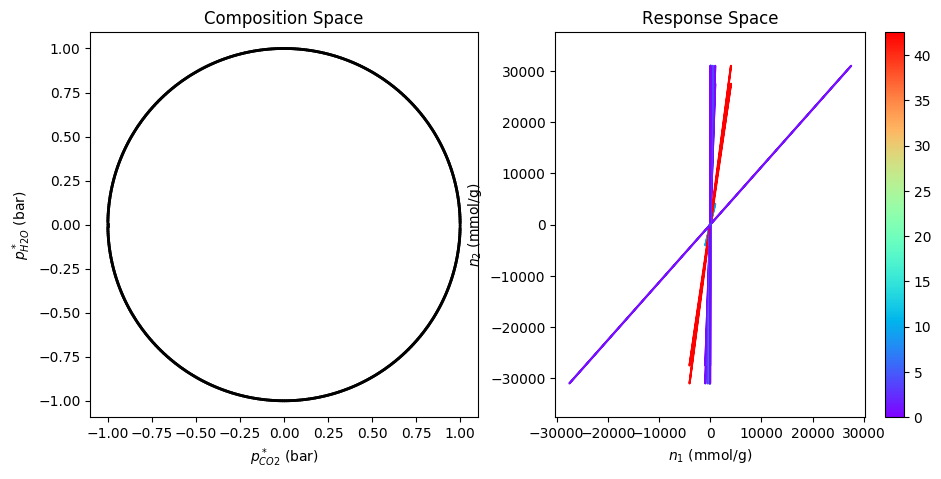

Condition number for 1 - 2: 99.961084
Condition number for 1 - 3: 467.950177
Condition number for 1 - 4: 58.385834
Condition number for 1 - 5: 2776.350752
Condition number for 1 - 6: 3131.271497
Condition number for 1 - 7: 246.934473
Condition number for 1 - 8: 40.070518
Condition number for 1 - 9: 83.942487
Condition number for 1 - 10: 33.376143
Condition number for 2 - 3: 445.271529
Condition number for 2 - 4: 384.902938
Condition number for 2 - 5: 41604.487696
Condition number for 2 - 6: 50010.159430
Condition number for 2 - 7: 369.124902
Condition number for 2 - 8: 247.718601
Condition number for 2 - 9: 123.937831
Condition number for 2 - 10: 2270.302062
Condition number for 3 - 4: 2281.371909
Condition number for 3 - 5: 653.377894
Condition number for 3 - 6: 736.163788
Condition number for 3 - 7: 1707.048465
Condition number for 3 - 8: 1446.526682
Condition number for 3 - 9: 610.980110
Condition number for 3 - 10: 29274.768185
Condition number for 4 - 5: 7775.598380
Condition numb

PyObject <matplotlib.colorbar.Colorbar object at 0x7f7690c14e10>

In [73]:
plot_all_responses("CO2", "H2O")

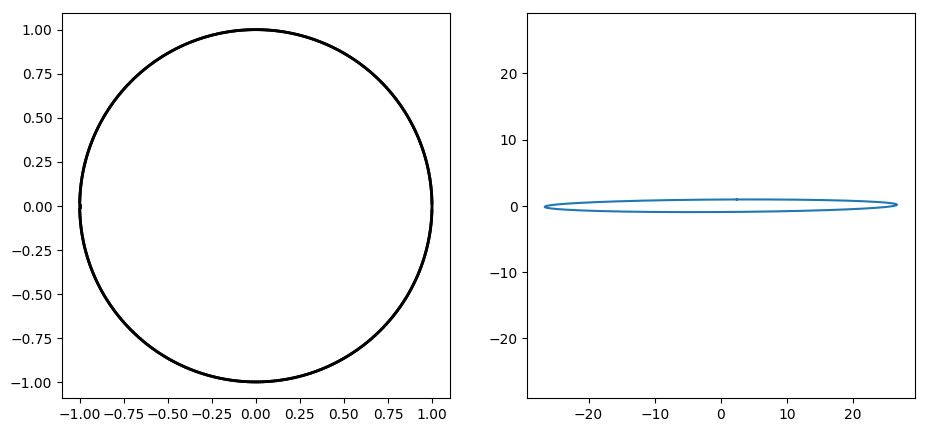

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
eigenvalues:
2-element Array{Float64,1}:
   0.8906181639106182
 708.813616273863    
eigenvectors:
2×2 Array{Float64,2}:
  0.00600874  -0.999982  
 -0.999982    -0.00600874

In [37]:
H = make_h_matrix2(3,4,"CO2", "H2O_TIP4PEw")
figure(figsize=(11, 5))
subplot(121, aspect="equal")
θ = range(0, stop=2*π, length=500)[1:end-1]
p = transpose(hcat(cos.(θ), sin.(θ))) # set pt change
for i = 1:length(θ)-1
    plot(p[1, i:i+1], p[2, i:i+1], lw=2, c="k")
end
xlim([-1.1, 1.1])
ylim([-1.1, 1.1])
axis("equal")

ax = subplot(122)
axis("equal")
S = perform_svd("CO2", "H2O_TIP4PEw")
biggest_σ₂ = maximum(S[:, :, 2])

cnorm = PyPlot.matplotlib[:colors][:Normalize](vmin=0.0, vmax=biggest_σ₂)

m = plt[:cm][:ScalarMappable](norm=cnorm, cmap=plt[:cm][:rainbow])
m[:set_array]([]) # trick

θ_response = collect(range(0, stop=2*π, length=250))#[1:end - 1]
θ_response[1] = deepcopy(θ_response[end])
p_response = transpose(hcat(cos.(θ_response), sin.(θ_response))) # set pt change
n = H * p_response # required input
#for i = 1:length(θ_response) - 1
#    plot(n[1, i:i+1], n[2, i:i+1], alpha=0.75, lw=3, c="#" * string(hex(cols[k])))#, label = label)
#end
plot(n[1,:], n[2, :])
S[3,4,:]

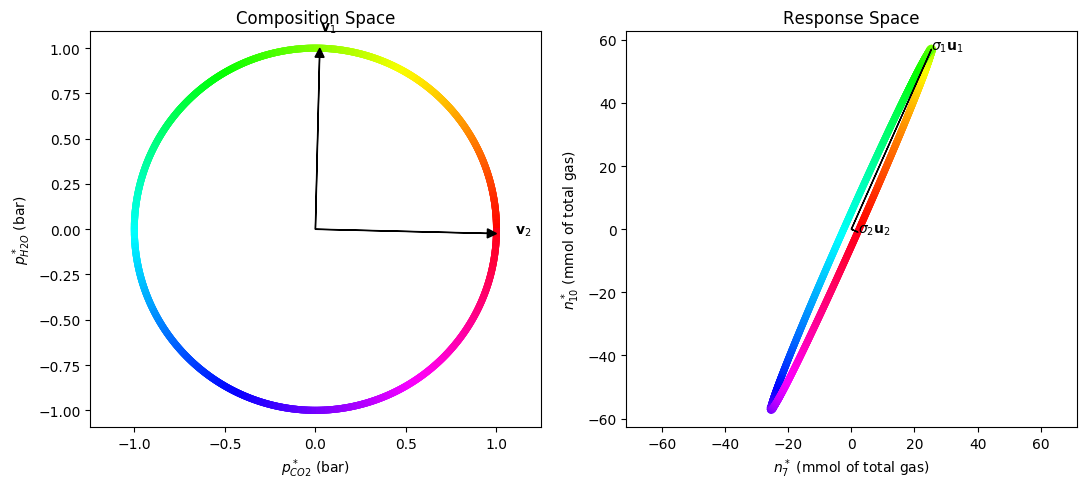

In [69]:
plot_response(7, 10, "CO2", "H2O")

In [70]:
sigma = perform_svd("H2O", "CO2")
analyze_svd(sigma)

The most sensitive pair of MOFs is MIL-101-NH2 and MIL-125
The least sensitive pair of MOFs is MIL-68 and ZIF-8


In [19]:
#@testset "Sensor Tests" begin
#    H = make_h_matrix(3, 5, "CO2", "C2H6")
#    G = [(8.91e-5) (4.84e-5); (1.87e-5) (4.68e-5)] .- [5.84e-6; 9.56e-6]
#    @test isapprox(H, G)
#end

In [18]:
@testset "MOF to index test" begin
    @test isapprox(mof2index("COF-103"), 4)
end

┌ Error: No MOF matched the given MOF name
└ @ Main In[17]:6


MOF to index test: Test Failed at In[18]:2
  Expression: isapprox(mof2index("COF-103"), 4)
   Evaluated: isapprox(1, 4)
Stacktrace:
 [1] macro expansion at ./In[18]:2 [inlined]
 [2] macro expansion at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.0/Test/src/Test.jl:1083 [inlined]
 [3] top-level scope at ./In[18]:2
Test Summary:     | Fail  Total
MOF to index test |    1      1


TestSetException: Some tests did not pass: 0 passed, 1 failed, 0 errored, 0 broken.